## Exploration - EDA and Data Cleaning

use the learned representation to develop a visualization of the items and users, e.g., using T-SNE or UMAP. The visualization should somehow integrate additional information (features, metadata, or genre tags) to illustrate how items are distributed in the learned space.

This file requires input csv file: user_ids.csv and dominant_trackgenre.csv. user_ids.csv. track_ids.csv is available only in scratch/yw5280 and rquires permission to access. It is also too large to be committed to github. Please contact yw5280@nyu.edu for assistance if needed.

This file outputs csv file: df_final.csv which is used in 'UMAP visualization.ipynb'

In [246]:
#pip install --pre umap-learn

### Setup packages and enviornment

In [1]:
# import pyspark as spark

import os
import sqlite3

import pandas as pd
import numpy as np
import itertools
from collections import Counter

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import umap
import umap.plot
import matplotlib.pyplot as plt
import time
import datetime

# from IPython.display import display
# import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [2]:
import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

In [3]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://127.0.0.1:35743 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 32.00 GiB


In [4]:
# Setup and configure spark session
spark = SparkSession.builder \
  .master("local") \
  .appName("parquet_example") \
  .config('spark.sql.execution.arrow.pyspark.enabled', True) \
  .config('spark.sql.session.timeZone', 'UTC') \
  .config('spark.driver.memory','32G') \
  .config('spark.ui.showConsoleProgress', True) \
  .config('spark.sql.repl.eagerEval.enabled', True) \
  .getOrCreate()

# Enable Arrow-based columnar data
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

### Load data and data cleaning

#### Import data

Some preparations for reading learned latent factors output by ALS. We here read a folder of parquet files into 'csv_file.csv' and will read from 'csv_file.csv' later on.

In [5]:
# Read data from hdfs
# df_val = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_validation.parquet')
# df_test = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_test.parquet')
df_train = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_train_new.parquet')
#spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/AdditionalFiles')

# Union all training+val+test data
# df = df_test.unionAll(df_val).unionAll(df_train)

In [6]:
import glob
files_user = (glob.glob("/home/yw5280/1004_Final_Test/user_ids/*.parquet"))
files_track = (glob.glob("/home/yw5280/1004_Final_Test/track_ids/*.parquet"))
files_user_factor = (glob.glob("/home/yw5280/1004_Final_Test/user_matrix/*.parquet"))
files_item_factor = (glob.glob("/home/yw5280/1004_Final_Test/item_matrix/*.parquet"))

Creating empty csv files and read and save parquet into csv

In [7]:
# # Create an empty csv file and write the first parquet file with headers
# with open('user_ids.csv','w') as csv_file:
# #     print('Reading par_file1.parquet')
# #     df = pd.read_parquet('par_file1.parquet')
# #     df.to_csv(csv_file, index=False)
# #     print('par_file1.parquet appended to csv_file.csv\n')
#     csv_file.close()

In [8]:
# # open files and append to csv_file.csv
# for f in files_user:
#     print(f'Reading {f}')
#     df = pd.read_parquet(f)
#     with open('user_ids.csv','a') as file:
#         df.to_csv(file, header=False, index=False)
#         print(f'{f} appended to user_ids.csv\n')

In [9]:
# # Create an empty csv file and write the first parquet file with headers
# with open('track_ids.csv','w') as csv_file:
# #     print('Reading par_file1.parquet')
# #     df = pd.read_parquet('par_file1.parquet')
# #     df.to_csv(csv_file, index=False)
# #     print('par_file1.parquet appended to csv_file.csv\n')
#     csv_file.close()

In [10]:
# # open files and append to csv_file.csv
# for f in files_track:
#     print(f'Reading {f}')
#     df = pd.read_parquet(f)
#     with open('track_ids.csv','a') as file:
#         df.to_csv(file, header=False, index=False)
#         print(f'{f} appended to track_ids.csv\n')

In [11]:
# # Create an empty csv file and write the first parquet file with headers
# with open('user_matrix.csv','w') as csv_file:
# #     print('Reading par_file1.parquet')
# #     df = pd.read_parquet('par_file1.parquet')
# #     df.to_csv(csv_file, index=False)
# #     print('par_file1.parquet appended to csv_file.csv\n')
#     csv_file.close()

In [16]:
# # open files and append to csv_file.csv
# for f in files_user_factor:
#     print(f'Reading {f}')
#     df = pd.read_parquet(f)
#     with open('user_matrix.csv','a') as file:
#         df.to_csv(file, header=False, index=False)
#         print(f'{f} appended to user_matrix.csv\n')

In [20]:
# # Create an empty csv file and write the first parquet file with headers
# with open('item_matrix.csv','w') as csv_file:
# #     print('Reading par_file1.parquet')
# #     df = pd.read_parquet('par_file1.parquet')
# #     df.to_csv(csv_file, index=False)
# #     print('par_file1.parquet appended to csv_file.csv\n')
#     csv_file.close()

In [22]:
# # open files and append to csv_file.csv
# for f in files_item_factor:
#     print(f'Reading {f}')
#     df = pd.read_parquet(f)
#     with open('item_matrix.csv','a') as file:
#         df.to_csv(file, header=False, index=False)
#         print(f'{f} appended to item_matrix.csv\n')

Read item factors and user factors directly from saved csv files

In [7]:
user_ids = pd.read_csv('user_ids.csv', header = None)
user_ids.columns = ['user_id','user_string_index']
track_ids = pd.read_csv('track_ids.csv', header = None)
track_ids.columns = ['track_id','track_string_index']

user_factor = pd.read_csv('user_matrix.csv', header = None)
user_factor.columns = ['user_string_index','user_factor']
item_factor = pd.read_csv('item_matrix.csv', header = None)
item_factor.columns = ['track_string_index','item_factor']

In [8]:
# Read track metadata
conn = sqlite3.connect("/scratch/work/courses/DSGA1004-2021/MSD/AdditionalFiles/track_metadata.db")
cur = conn.cursor()
df_meta = pd.read_sql_query("SELECT * FROM songs", conn)
cur.close()
conn.close()

In [7]:
# # read artist data
# # There are already many information readily available in the metadata about artists
# conn = sqlite3.connect("/scratch/work/courses/DSGA1004-2021/MSD/AdditionalFiles/artist_term.db")
# cur = conn.cursor()
# df_artterm = pd.read_sql_query("SELECT * FROM artist_term", conn)
# df_artmbt = pd.read_sql_query("SELECT * FROM artist_mbtag", conn)
# # df_mbt = pd.read_sql_query("SELECT * FROM mbtags", conn)
# # df_term = pd.read_sql_query("SELECT * FROM terms", conn)
# # df_artist = pd.read_sql_query("SELECT * FROM artists", conn)
# cur.close()
# conn.close()

In [9]:
# read tag data
conn = sqlite3.connect("/scratch/work/courses/DSGA1004-2021/MSD/AdditionalFiles/lastfm_tags.db")
cur = conn.cursor()
df_tags = pd.read_sql_query("SELECT * FROM tags", conn)
df_tidtag = pd.read_sql_query("SELECT * FROM tid_tag", conn)
df_tid = pd.read_sql_query("SELECT * FROM tids", conn)
cur.close()
conn.close()

In [9]:
# read song data
# I don't think there are any tags/ features related to a song_id readily available in the /AdditionalFiles

In [10]:
# rename keys for table merging
df_tidtag.columns = ['tid_num','tag_num','val']
df_tags.index.names = ['tag_num']
df_tid.index.names = ['tid_num']
df_meta.rename(columns={'track_id':'tid'}, inplace=True)

#### Cleaning artist data. Note that after careful analysis, artist data will not be used now or later in this project

In [11]:
# df_artterm = pd.DataFrame(df_artterm.groupby('artist_id')['term'].apply(list))

In [12]:
# # Many artists have multiple mbtags and many have none
# # Total # of artists with at least one mbtag: 8838
# df_artmbt = pd.DataFrame(df_artmbt.groupby('artist_id')['mbtag'].apply(list))

In [13]:
# df_artists = pd.merge(
#     df_artterm,
#     df_artmbt,
#     how = 'outer',
#     on = 'artist_id',
#     sort = False)
# # rename columns
# df_artists.columns = ['artist_term', 'artist_mbtag']

#### Cleaning genre tag data

In [11]:
# Since pandas df index start from 0, 
# we subtract both track_id and tag_id by 1 to match the default index of pandas df
df_tidtag['tid_num'] -= 1
df_tidtag['tag_num'] -= 1

In [12]:
# merge tags and track id
df_all = pd.merge(
    df_tidtag,
    df_tags,
    how = 'outer',
    on = 'tag_num',
    sort = False)

df_all = pd.merge(
    df_all,
    df_tid,
    how = 'outer',
    on = 'tid_num',
    sort = False)

In [13]:
# get a list of [(genre, val(in %))] pairs for each track
df_all = pd.DataFrame(df_all.groupby('tid')[['tag', 'val']].apply(lambda g: dict(map(tuple, g.values.tolist()))))

In [14]:
# rename the column
df_all.columns = ['track_genre_val']

#### Merging artist, genre tag data with metadata

In [15]:
# merge metadata with track tags
df_meta = pd.merge(
    df_meta,
    df_all,
    how = 'outer',
    on = 'tid',
    sort = False)

In [19]:
# # merge metadata with artist mbtag and term
# df_meta = pd.merge(
#     df_meta,
#     df_artists,
#     how = 'outer',
#     on = 'artist_id',
#     sort = False)

In [16]:
# rename column for ease of merging
df_meta.rename(columns={'tid':'track_id'}, inplace=True)

#### Sampling and cleaning training+val+test data for plotting

In [17]:
# random sampling 400k samples from the entire dataset
# df_train.toPandas induces error because df_train too large (2m pyspark df)
np.random.seed = 42
df_samp = df_train.sample(False, 0.1, seed=66).limit(600000)

In [18]:
# convert to pandas df
samp_array = df_samp.collect()
df_samp = df_samp.toPandas()

In [19]:
# merge to get df for plot
df_plot = pd.merge(
    df_meta,
    df_samp,
    how = 'inner',
    on = 'track_id',
    sort = False)

In [20]:
# drop unnecessary column
df_plot = df_plot.drop('__index_level_0__', axis = 1)
# replace 0 release year with nan
df_plot['year'] = df_plot['year'].replace(['0', 0], np.nan)

### Join for user and track string index after ALS model

In [21]:
df_plot = pd.merge(
    df_plot,
    user_ids,
    how = 'inner',
    on = 'user_id',
    sort = False)

In [22]:
df_plot = pd.merge(
    df_plot,
    track_ids,
    how = 'inner',
    on = 'track_id',
    sort = False)

### Join for userfactors and itemfactors after ALS model

In [23]:
df_plot = pd.merge(
    df_plot,
    user_factor,
    how = 'inner',
    on = 'user_string_index',
    sort = False)

In [24]:
df_plot = pd.merge(
    df_plot,
    item_factor,
    how = 'inner',
    on = 'track_string_index',
    sort = False)

In [29]:
df_plot

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_genre_val,user_id,count,user_string_index,track_string_index,user_factor,item_factor
0,TRWVTDX128F931ECEF,Paper Planes,SOUOEMP12A8C13866E,Decent Work For Decent Pay,ARDDMYP1187B9B8AE4,b22d45dd-deae-4663-a782-542db02e25cf,M.I.A.,206.13179,0.912247,0.644803,NaN,"{'pop': 10.0, 'cool': 2.0, 'experimental': 2.0...",3affb0a71a06ddebbb9072d8ad827c2138d048ef,2,12869.0,104.0,[0. 0.22800162 0.00995558 0. 0...,[0.00551674 0.12907887 0.18673147 0.02059709 0...
1,TRWVTDX128F931ECEF,Paper Planes,SOUOEMP12A8C13866E,Decent Work For Decent Pay,ARDDMYP1187B9B8AE4,b22d45dd-deae-4663-a782-542db02e25cf,M.I.A.,206.13179,0.912247,0.644803,NaN,"{'pop': 10.0, 'cool': 2.0, 'experimental': 2.0...",9aa0651b8f87752b3114157b25537d9c33049aa2,1,504.0,104.0,[0. 0.03079134 0.05358454 0.02317308 0...,[0.00551674 0.12907887 0.18673147 0.02059709 0...
2,TRWVTDX128F931ECEF,Paper Planes,SOUOEMP12A8C13866E,Decent Work For Decent Pay,ARDDMYP1187B9B8AE4,b22d45dd-deae-4663-a782-542db02e25cf,M.I.A.,206.13179,0.912247,0.644803,NaN,"{'pop': 10.0, 'cool': 2.0, 'experimental': 2.0...",79a1ba30cec2ee1509f3c2df697916fe901b37e9,3,598.0,104.0,[0.02599008 0.05001412 0.01484298 0.00823193 0...,[0.00551674 0.12907887 0.18673147 0.02059709 0...
3,TRWVTDX128F931ECEF,Paper Planes,SOUOEMP12A8C13866E,Decent Work For Decent Pay,ARDDMYP1187B9B8AE4,b22d45dd-deae-4663-a782-542db02e25cf,M.I.A.,206.13179,0.912247,0.644803,NaN,"{'pop': 10.0, 'cool': 2.0, 'experimental': 2.0...",f121dc68b37aa5f295940d3108f9cd4949c6f382,3,11038.0,104.0,[0.541773 0. 0. 0. 0...,[0.00551674 0.12907887 0.18673147 0.02059709 0...
4,TRWVTDX128F931ECEF,Paper Planes,SOUOEMP12A8C13866E,Decent Work For Decent Pay,ARDDMYP1187B9B8AE4,b22d45dd-deae-4663-a782-542db02e25cf,M.I.A.,206.13179,0.912247,0.644803,NaN,"{'pop': 10.0, 'cool': 2.0, 'experimental': 2.0...",b60c136a565621b6261b7c4d41b5756cc681dc1d,2,19964.0,104.0,[0.00738652 0.08792698 0. 0. 0...,[0.00551674 0.12907887 0.18673147 0.02059709 0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84074,TRAGVHG12903CEFC62,H.m.j.,SOQTXZE12A67ADA74A,Dragonslayer,ARIFAA91187FB37EA6,8097243f-7a3d-435a-a11e-0c5f886528e0,Dream Evil,164.36200,0.653299,0.482431,2002.0,"{'heard on Pandora': 0.0, 'Power metal': 100.0...",0885a6856cb62fbb27fbbb060c3b5d66e9afa6c8,1,13326.0,97231.0,[0.00045793 0.09077659 0. 0.02956144 0...,[6.7974726e-04 0.0000000e+00 6.0554990e-03 0.0...
84075,TREWXVE12903CF221C,Into The Moonlight,SOJIAPL12A67AE23EE,The Book Of Heavy Metal,ARIFAA91187FB37EA6,8097243f-7a3d-435a-a11e-0c5f886528e0,Dream Evil,260.10077,0.653299,0.482431,2004.0,"{'Progressive rock': 9.0, 'swedish': 22.0, 'ok...",0885a6856cb62fbb27fbbb060c3b5d66e9afa6c8,1,13326.0,114005.0,[0.00045793 0.09077659 0. 0.02956144 0...,[0. 0. 0.00658189 0.00013213 0...
84076,TRSGHJT128F930B8DD,Metal Invasion,SOFCWOC12AB0181B7B,Eternity,AR60SB71187B98DB4D,d4310265-7415-4802-b4f3-4b762217efbb,Freedom Call,409.02485,0.594303,0.504924,2002.0,"{'Power metal': 100.0, 'heavy metal': 3.0, 'sp...",0885a6856cb62fbb27fbbb060c3b5d66e9afa6c8,2,13326.0,73778.0,[0.00045793 0.09077659 0. 0.02956144 0...,[0. 0. 0. 0.00122118 0...
84077,TRVHIWS12903CF1CA2,Forevermore,SOTIEMO12A6D4F6DE5,Evilized,ARIFAA91187FB37EA6,8097243f-7a3d-435a-a11e-0c5f886528e0,Dream Evil,307.93098,0.653299,0.482431,2003.0,"{'Power metal': 100.0, 'Awesome': 20.0, 'Balla...",0885a6856cb62fbb27fbbb060c3b5d66e9afa6c8,1,13326.0,107522.0,[0.00045793 0.09077659 0. 0.02956144 0...,[0.00045911 0. 0. 0.00046286 0...


In [25]:
test = df_plot[
    [
        "duration",
        "artist_familiarity",
        "artist_hotttnesss",
        "count",
        "year"
    ]
].values

In [31]:
df_plot[
    [
        "duration",
        "artist_familiarity",
        "artist_hotttnesss",
        "count",
        "year"
    ]
]

,duration,artist_familiarity,artist_hotttnesss,count,year
0,206.13179,0.912247,0.644803,2,NaN
1,206.13179,0.912247,0.644803,1,NaN
2,206.13179,0.912247,0.644803,3,NaN
3,206.13179,0.912247,0.644803,3,NaN
4,206.13179,0.912247,0.644803,2,NaN
...,...,...,...,...,...
84074,164.36200,0.653299,0.482431,1,2002.0
84075,260.10077,0.653299,0.482431,1,2004.0
84076,409.02485,0.594303,0.504924,2,2002.0
84077,307.93098,0.653299,0.482431,1,2003.0


In [34]:
type(test)

numpy.ndarray

### Unnecessary but Simple EDA: matplotlib + seaborn pairplot

In this section, we will analyze the data and decide which genre/ tag to be assigned to an artist/ track. One artist will be resulted in one tag and one track will be associated with one genre. We do this single assignment for the ease of UMAP learning.

In [49]:
df_plot.describe()

,duration,artist_familiarity,artist_hotttnesss,year,count,user_string_index,track_string_index
count,84079.000000,84079.000000,84079.000000,69951.000000,84079.000000,84079.000000,84079.000000
mean,247.450555,0.740433,0.543940,2000.475390,2.257413,8847.613268,20706.272077
std,97.398078,0.117468,0.128194,9.565611,3.893776,6594.774722,25685.783406
min,1.122810,-1.000000,0.000000,1929.000000,1.000000,2.000000,0.000000
25%,195.944040,0.674497,0.468773,1997.000000,1.000000,3006.000000,2426.000000
50%,233.508120,0.757952,0.532283,2004.000000,1.000000,7668.000000,10016.000000
75%,280.633020,0.828303,0.587705,2007.000000,2.000000,14412.000000,29339.000000
max,3024.665670,1.000000,1.082503,2010.000000,342.000000,22170.000000,119507.000000


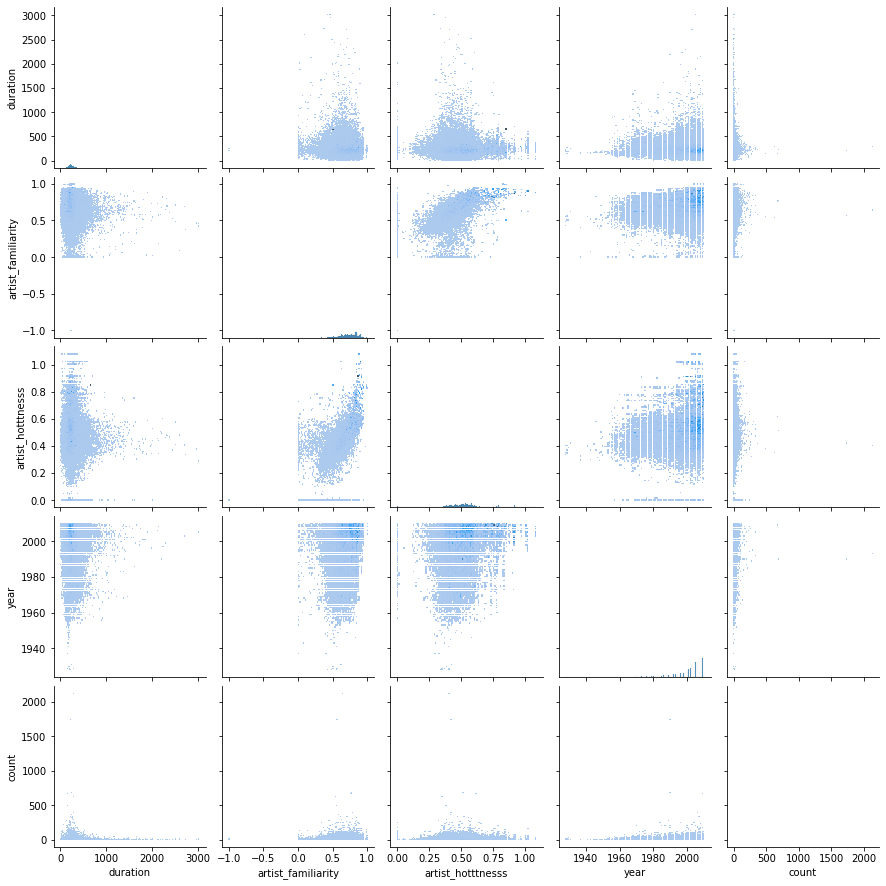

In [59]:
import seaborn as sns
sns.pairplot(df_plot, kind = 'hist') #hue?

#### Artist vs genre tags eda

This is useful for selecting the most descriptive artist genre tag.

Each artist will be assigned with a genre tag that has the highest appearance rank among all artists. The rank of a genre is calculated from the total number of times it appears in the entire MSD dataset. (Assumption made: the more times an artist genre appears the hotter/ more popular this genre is)

This would introduce a somewhat popularity bias but still would be descriptive for a specific artist

In [25]:
# # most listened to by different users (1 user = 1 count; any more counts by the same user are not calculated)
# most_artist = pd.DataFrame(df_plot[["artist_name", "artist_id"]].value_counts(ascending = True))
# most_artist.columns = ['count']
# most_artist['rank'] = most_artist['count'].rank()

In [26]:
# mostlistened_artist = pd.DataFrame(df_plot.groupby(['artist_name','artist_id'])['count'].apply(sum))\
#                                     .sort_values('count', ascending = True)
# mostlistened_artist['rank'] = mostlistened_artist['count'].rank()

In [27]:
# most_artist_20 = most_artist.tail(20)
# mostlistened_artist_20 = mostlistened_artist.tail(20)

Text(0.5, 1.0, 'top 20 artists listened the most times')

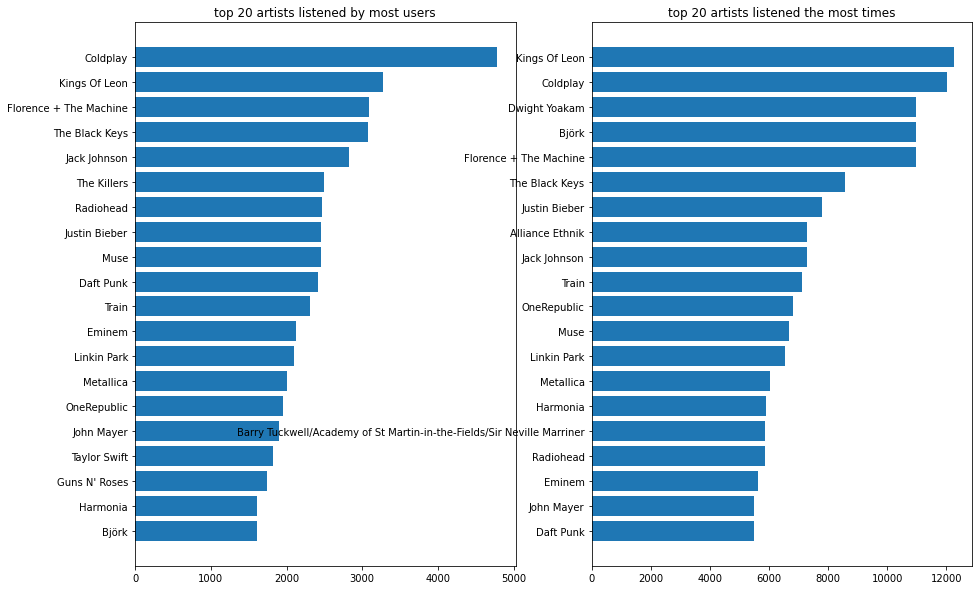

In [334]:
# # side by side bar chart: most listened artists (by most users versus by most times)
# x1, y1, x2, y2 = most_artist_20.index.get_level_values(0), most_artist_20['count'],\
#                 mostlistened_artist_20.index.get_level_values(0), mostlistened_artist_20['count']
# fig = plt.figure(figsize = (15,10))
# ax = fig.add_subplot(121)
# plt.barh(x1,y1)
# plt.title('top 20 artists listened by most users')
# ax = fig.add_subplot(122)
# plt.barh(x2,y2)
# plt.title('top 20 artists listened the most times')

##### Selecting artist tags (for artists with multiple tags)

In [28]:
# artist_term = list(df_plot['artist_term'].dropna())
# artist_term = pd.DataFrame(list(itertools.chain(*artist_term)))
# artist_term = pd.DataFrame(artist_term.value_counts().sort_values(ascending = True))
# artist_term.columns = ['count']
# artist_term['rank'] = artist_term.rank()

In [29]:
# artist_mbtag = list(df_plot['artist_mbtag'].dropna())
# artist_mbtag = pd.DataFrame(list(itertools.chain(*artist_mbtag)))
# artist_mbtag = pd.DataFrame(artist_mbtag.value_counts().sort_values(ascending = True))
# artist_mbtag.columns = ['count']
# artist_mbtag['rank'] = artist_mbtag.rank()

In [30]:
# artist_term_20 = artist_term.tail(20)
# artist_mbtag_20 = artist_mbtag.tail(20)

Text(0.5, 1.0, 'top 20 mbtags of the most listened artists')

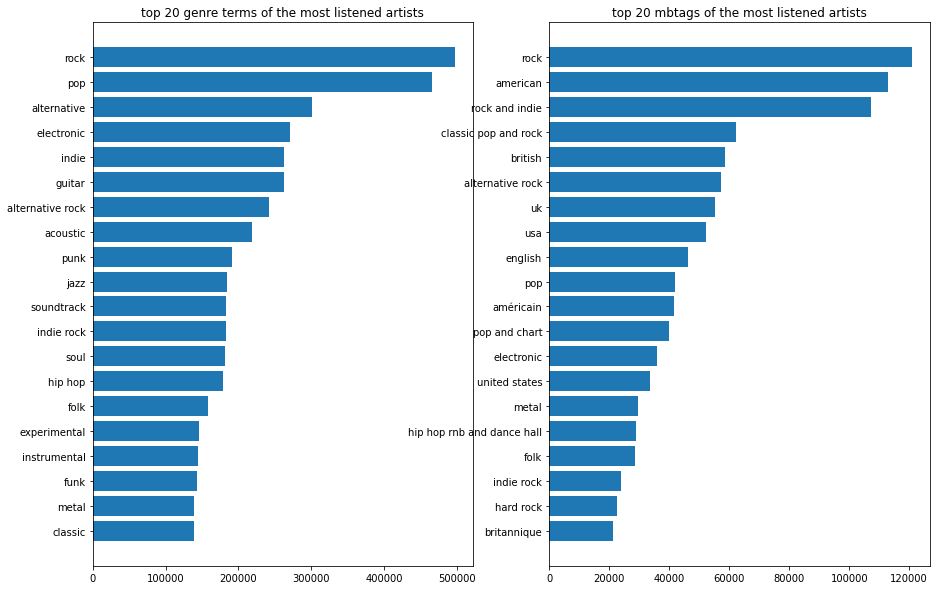

In [339]:
# # side by side bar chart: top 20 artist term vs mbtags of most listened artists
# x1, y1, x2, y2 = artist_term_20.index.get_level_values(0), artist_term_20['count'],\
#                 artist_mbtag_20.index.get_level_values(0), artist_mbtag_20['count']
# fig = plt.figure(figsize = (15,10))
# ax = fig.add_subplot(121)
# plt.barh(x1,y1)
# plt.title('top 20 genre terms of the most listened artists')
# ax = fig.add_subplot(122)
# plt.barh(x2,y2)
# plt.title('top 20 mbtags of the most listened artists')

#### Track analysis

This could also be used for selecting the most descriptive genre tag for a track

In [60]:
# most listened to by different users (1 user = 1 count; any more counts by the same user are not calculated)
most_track = pd.DataFrame(df_plot[["track_id", "title"]].value_counts(ascending = True))
most_track.columns = ['count']

In [61]:
mostlistened_track = pd.DataFrame(df_plot.groupby(["track_id", "title"])['count'].apply(sum))\
                                    .sort_values('count', ascending = True)

In [62]:
most_track_20 = most_track.tail(20)
mostlistened_track_20 = mostlistened_track.tail(20)

Text(0.5, 1.0, 'top 20 tracks listened the most times')

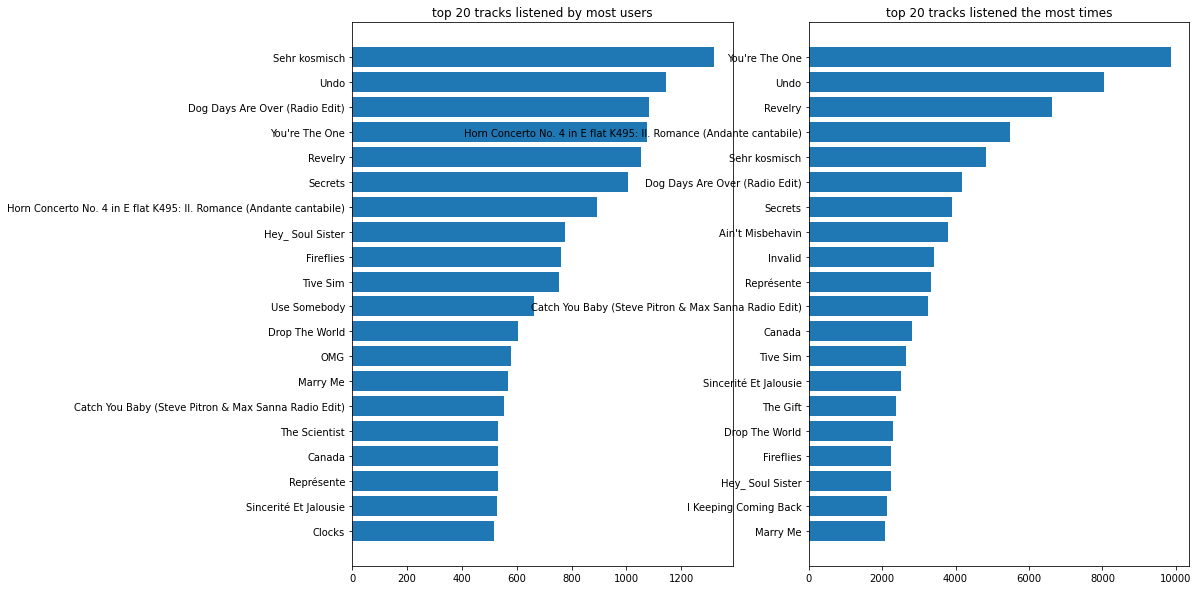

In [63]:
# side by side bar chart: most listened artists (by most users versus by most times)
x1, y1, x2, y2 = most_track_20.index.get_level_values(1), most_track_20['count'],\
                mostlistened_track_20.index.get_level_values(1), mostlistened_track_20['count']
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(121)
plt.barh(x1,y1)
plt.title('top 20 tracks listened by most users')
ax = fig.add_subplot(122)
plt.barh(x2,y2)
plt.title('top 20 tracks listened the most times')

##### A demograph of the number of times track being listend to

Most tracks are only listened to once or twice. 

In [64]:
# track versus count pie chart
# most track are only listend to by once or twice
times = [*range(1,20,1)]
times_full = [*range(1, max(mostlistened_track['count']), 1)]
times_listened_to_1, times_listened_to_2 = {}, {}
for time in times:
    times_listened_to_1[str(time)] = len(mostlistened_track[mostlistened_track['count'] == time])/ len(mostlistened_track)
for time in times_full:
    times_listened_to_2[str(time)] = len(mostlistened_track[mostlistened_track['count'] == time])/ len(mostlistened_track)

In [65]:
times_df_1 = pd.DataFrame(list(times_listened_to_1.items()),columns = ['times listened to','%'])
times_df_2 = pd.DataFrame(list(times_listened_to_2.items()),columns = ['times listened to','%'])

<AxesSubplot:>

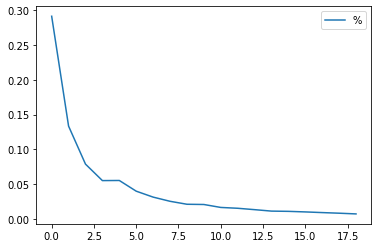

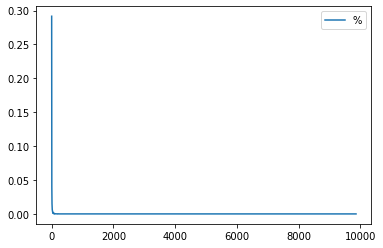

In [66]:
times_df_1.plot()
times_df_2.plot()

There is a clear decrease at range (1, 5) and there is almost no change in the range (1000, 8000) so we will binning the "number of times a track is listened to" by [1, 2, 3 - 5, 6-10, 11 - 49, 50 - 99, 100 - 999, >= 1000]

In [67]:
df_times = {'Once': len(mostlistened_track[mostlistened_track['count'] == 1])/ len(mostlistened_track),
            'Twice': len(mostlistened_track[mostlistened_track['count'] == 2])/ len(mostlistened_track),
            '3 - 5': len(mostlistened_track[mostlistened_track['count'].between(3,5)])/ len(mostlistened_track),
            '6-10': len(mostlistened_track[mostlistened_track['count'].between(6,10)])/ len(mostlistened_track),
            '11-49': len(mostlistened_track[mostlistened_track['count'].between(11,49)])/ len(mostlistened_track),
            '50-99': len(mostlistened_track[mostlistened_track['count'].between(50,99)])/ len(mostlistened_track),
            '100-999': len(mostlistened_track[mostlistened_track['count'].between(100,999)])/ len(mostlistened_track),
            '>999': len(mostlistened_track[mostlistened_track['count'] >= 1000])/ len(mostlistened_track)
           }
df_times = pd.DataFrame(list(df_times.items()),columns = ['times listened to','%'])

In [68]:
df_times = df_times.set_index('times listened to')

<AxesSubplot:ylabel='%'>

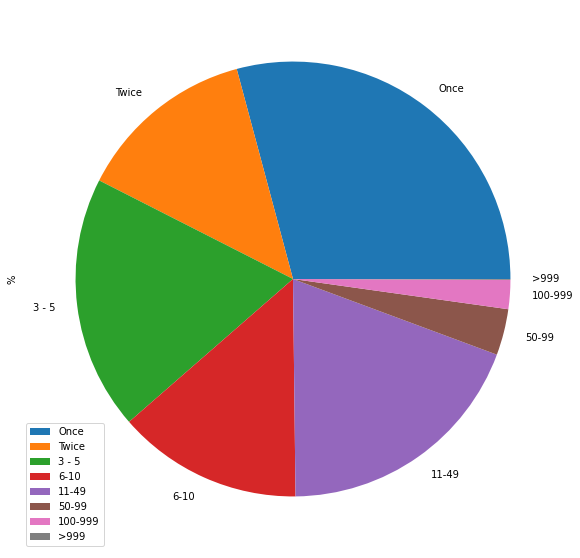

In [69]:
df_times.plot.pie(y = '%', figsize=(10, 10))
# label it!!

##### Selecting tags for tracks with multiple dominant genres

For tracks with multiple dominant genres, the most popular genre dominate the track genre and the popularity of a track genre is calculated from the total number of times this genre appears in the MSD. (Assumption made similar to the one in deciding artist genre/ tag popularity)

This could introduce a popularity bias but should be somewhat less biased than artist genre assignment (an artist's genre could be far more diverse than a track's genre and it could be trickier for us to assign a single genre to an artist. On the contrary, assigning one genre to a track sounds a little better)

In [50]:
track_genre_full = df_plot['track_genre_val'].dropna()
track_genre_full = list(track_genre_full.apply(lambda x: list(x.keys())))
track_genre_full = list(itertools.chain(*track_genre_full))
track_genre_dict = Counter((genre for genre in track_genre_full))
genre = pd.DataFrame(list(track_genre_dict.items()),columns = ['genre','count']).sort_values('count', ascending = True)

In [51]:
# rank the genres by the number of times they appear in the MSD track_genre
# For tracks with multiple dominant genres, the most popular genre dominate the track genre
genre['rank'] = genre['count'].rank()

In [52]:
genre_10 = genre.tail(13)
genre_50 = genre.tail(50)

<BarContainer object of 13 artists>

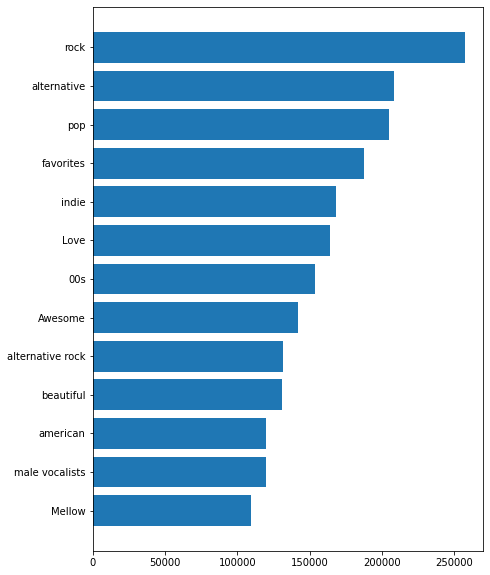

In [76]:
# top 20 most popular genres (by number of times they appear)
x1, y1 = genre_10['genre'], genre_10['count']
fig = plt.figure(figsize = (7,10))
plt.barh(x1,y1)

In [45]:
# def contains_fav(str):
#     if 'favorite' in str:
#         return True
#     if 'Favorite' in str:
#         return True
#     if 'favourite' in str:
#         return True
#     if 'Favourite' in str:
#         return True
#     return False

In [53]:
# genre_50.to_csv('genre_50.csv')
# genre_10.to_csv('genre_10.csv')

### Data Cleaning continued (after EDA) for track&artist genres

In this section, we will assign one genre/ tag to each of an artist/ track based on the popularity rankings of the tags made in EDA. The larger the rank, the more popular the tag.

If there is a tie in the tag rank - tie not observed.

Cleaning for artist term and save result

In [81]:
# # Cleaning for artist term
# import math
# #optimizable

# def select_term(genre_lst):
#     """
#     inputs: 
#         track(boolean):
#             True means it is from the track_genre_val column, 
#             otherwise artist_mbtag/ artist_term
#         row: input row to be cleaned
#     return: a dominant genre/ tag for a track/ artist
#     """
# #     if genre_lst != genre_lst: return row # check for nan rows
# #     if track:
# #         genre_lst = find_max_genre(row)
# #         rank = [int(genre[genre['genre'] == tag]['rank']) for tag in genre_lst]
# #     else:
#     rank = [int(artist_term['rank'][tag]) for tag in genre_lst]
#     max_index = [idx for idx, val in enumerate(rank) if val == max(rank)]
#     dominant_genre = [genre_lst[idx] for idx in max_index]
#     return dominant_genre

In [83]:
# genre_lst = df_plot['artist_term'].dropna()
# dominant_genre_dropna = genre_lst.apply(lambda x: select_term(x))
# dominant_genre_dropna.to_csv('dominan_genre.csv')
# # df_plot.to_csv('cleaned_df.csv')

Cleaning for track genre and save result

In [54]:
def select_genre(row):
    """
    inputs: 
        track(boolean):
            True means it is from the track_genre_val column, 
            otherwise artist_mbtag/ artist_term
        row: input row to be cleaned
    return: a dominant genre/ tag for a track/ artist
    """
#     if row != row: return row # check for nan rows
#     if track:
    key, value = list(row.keys()), list(row.values())
    genre_lst = list()
    itemMaxValue = max(value)
    # Iterate over all the items in dictionary to find keys with max value
    for i in range(len(value)):
        if value[i] == itemMaxValue:
            genre_lst.append(key[i])
    rank = [int(genre['rank'][tag]) for tag in genre_lst]
#     else:
#         genre_lst = row
#         rank = [int(artist_term['rank'][tag]) for tag in row]
    max_rank = max(rank)
    max_index = [idx for idx, val in enumerate(rank) if val == max_rank]
    dominant_genre = [genre_lst[idx] for idx in max_index]
    return dominant_genre

In [55]:
genre = genre.set_index('genre')
track = df_plot['track_genre_val'].dropna()
dominant_track = track.apply(lambda x: select_genre(x))
dominant_track.to_csv('dominant_trackgenre.csv')

Read cleaned result and clean for plots and save results

In [56]:
def clean_word(string):
    if string != string:
        return 'NA'
    return string[2:-2]

In [57]:
# read cleaned data
# dominant_genre_dropna = pd.read_csv('dominan_genre.csv')
dominant_track_genre = pd.read_csv('dominant_trackgenre.csv')
# df_plot = df_plot.drop(['artist_term'], axis = 1)
df_plot = df_plot.drop(['track_genre_val'], axis = 1)

In [91]:
# df_plot = pd.concat(
#     [df_plot, dominant_genre_dropna],
#     axis = 1)

In [58]:
df_plot = pd.concat(
    [df_plot, dominant_track_genre],
    axis = 1)
df_plot = df_plot.drop('Unnamed: 0', axis = 1)

In [59]:
df_final = df_plot

In [60]:
# df_final['artist_term']=df_final['artist_term'].apply(lambda x: clean_word(x))
df_final['track_genre_val'] = df_final['track_genre_val'].apply(lambda x: clean_word(x))

In [68]:
df_final = df_final[['track_genre_val','year','item_factor']]

In [69]:
df_final = df_final[df_final['year'].notna()]

In [70]:
df_final

,track_genre_val,year,item_factor
19,80s,1984.0,[0. 0.02217899 0.01456057 0.08075973 0...
20,80s,1984.0,[0. 0.02217899 0.01456057 0.08075973 0...
21,80s,1984.0,[0. 0.02217899 0.01456057 0.08075973 0...
22,80s,1984.0,[0. 0.02217899 0.01456057 0.08075973 0...
23,80s,1984.0,[0. 0.02217899 0.01456057 0.08075973 0...
...,...,...,...
84073,NA,2002.0,[0. 0. 0. 0. 0...
84074,NA,2002.0,[6.7974726e-04 0.0000000e+00 6.0554990e-03 0.0...
84075,NA,2004.0,[0. 0. 0.00658189 0.00013213 0...
84076,NA,2002.0,[0. 0. 0. 0.00122118 0...


In [71]:
df_final.to_csv('df_final.csv')

### The rest goes to UMAP visualization